# 2021 Western North America heat wave
#### Start date	of the event: June 25, 2021, End date of the event:	July 7, 2021

Relevant info on the web:
- [Roth et al. paper that basically did the same analysis that we want to do](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2015JF003782)
- [Link to USGS stream gauge data](https://nwis.waterdata.usgs.gov/nwis/uv?cb_00060=on&cb_00065=on&cb_63680=on&format=gif_default&site_no=12101500&period=&begin_date=2021-06-1&end_date=2021-07-10)
- [Link to USGS stream gauge info](https://waterdata.usgs.gov/monitoring-location/12092000/#parameterCode=00065&period=P365D)
- [Wikipedia page about the heat dome event](https://en.wikipedia.org/wiki/2021_Western_North_America_heat_wave)

## Step 1: Download some data using ObsPy

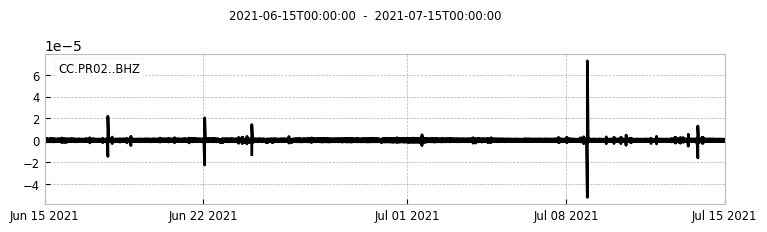

537.7121523800306


In [1]:
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import matplotlib.pyplot as plt
from time import perf_counter
from scipy.signal import spectrogram
import numpy as np
plt.style.use('bmh')
# seaborn-colorblind
t0 = perf_counter()

client = Client("IRIS")

t1 = UTCDateTime("2021-06-15T00:00:00")
t2 = UTCDateTime("2021-07-15T00:00:00")
# t2 = UTCDateTime("2021-07-08T00:00:00")

st = client.get_waveforms("CC", "PR02", "--", "BHZ", t1, t2, attach_response=True)

pre_filt = (0.1, 0.2, 25, 49)
st.remove_response(output='VEL', pre_filt=pre_filt)
st.plot()
print(perf_counter()-t0)

In [2]:
data = np.array([])
for tr in st:
    data=np.concatenate((data,tr.data))
data = np.array(data)

## Step 2: Make a spectrogram and plot it

In [3]:
f, t, Sxx = spectrogram(data, fs=50.0)

<ipython-input-4-921acb525483>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  c=plt.pcolormesh(t/86400, f, np.log10(np.abs(Sxx)), shading='flat',vmin=-17,vmax=-13)


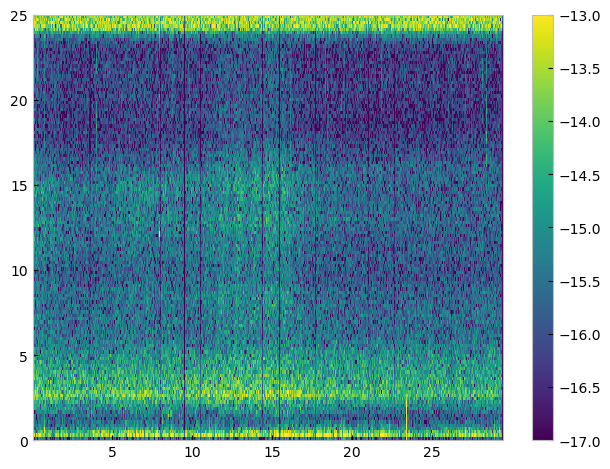

In [4]:
c=plt.pcolormesh(t/86400, f, np.log10(np.abs(Sxx)), shading='flat',vmin=-17,vmax=-13)
plt.colorbar(c)
plt.tight_layout()
plt.show()

## Step 3: Extract a particular frequency band, low-pass filter it, then make a plot
The thinking here is that this frequency band is related to water flow and/or sediment flux

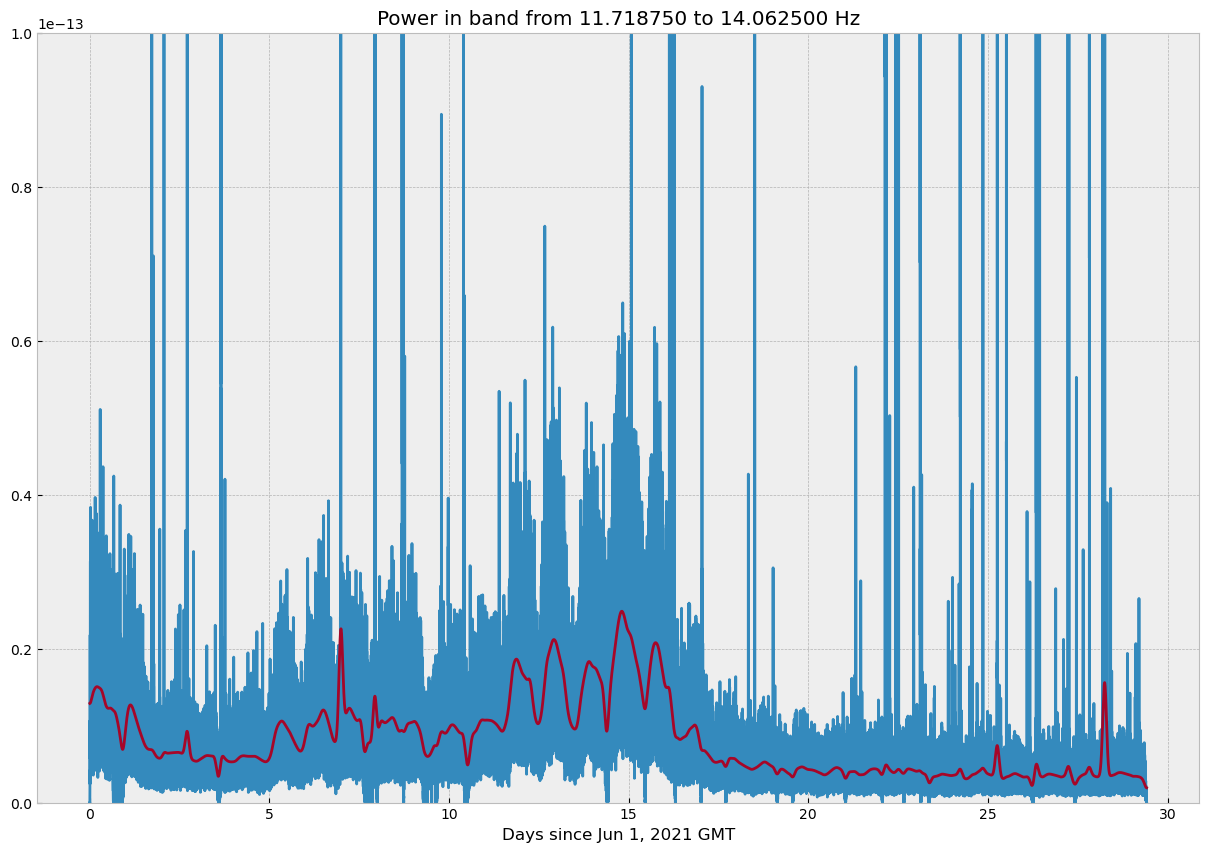

In [34]:
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

power_timeseries = np.abs( np.sum(Sxx[60:72,:],axis=0))

dt = 60
t_deci = np.arange(dt,max(t),dt)
p_filt = gaussian_filter(power_timeseries,1000)
p_fun = interp1d(t,p_filt)
p_deci = p_fun(t_deci)

fig,ax=plt.subplots(figsize=(15,10))
plt.plot(t/86400, power_timeseries  )
plt.plot(t_deci/86400, p_deci )
# plt.ylim([0, 1e-12])
plt.title('Power in band from %f to %f Hz'%(f[60],f[72]))
plt.xlabel('Days since Jun 1, 2021 GMT')
# plt.ylim([-16,-12])
# plt.yscale('log')
plt.ylim([0, 1e-13])
plt.show()

## Step 4: Load the stream gauge data and plot it

In [54]:
import pandas as pd
  
# read text file into pandas DataFrame
df = pd.read_csv("usgs-data.txt", sep="\t", header=28)

df["datetime"]

0        2021-02-24 15:15
1        2021-02-24 15:30
2        2021-02-24 15:45
3        2021-02-24 16:00
4        2021-02-24 16:15
               ...       
33700    2022-02-24 13:15
33701    2022-02-24 13:30
33702    2022-02-24 13:45
33703    2022-02-24 14:00
33704    2022-02-24 14:15
Name: datetime, Length: 33705, dtype: object

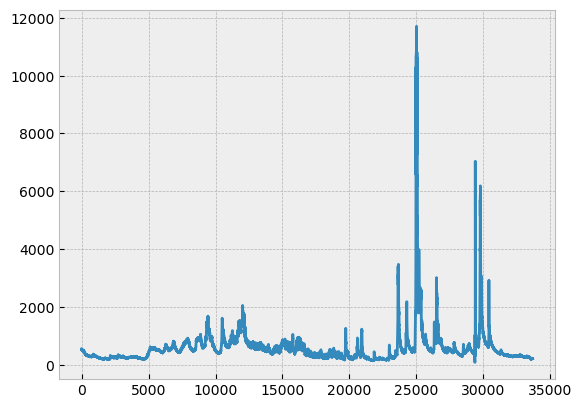

In [55]:
fig,ax=plt.subplots()
plt.plot(df['Flux'].to_list())
plt.show()

## Step 5: Compare seismic and stream gauge data.
Specifically: interpolate the stream gauge data so that it is on the same time grid as the spectral energy curve, then compare the two using a cross plot

## Step 6: Find some rainfall data and compare it in a similar way.